In [8]:
import os
import numpy as np
import scipy.io as sio
import natsort as n
import matplotlib.pyplot as plt

In [9]:
def get_mouse_data_and_score(mouseid, tag='Psyco_all_', rootdir='/home/pouple/PhD/Data/Analysis'):
    """ Simple function to extract data from matlab recordings
    """
    
    path = [os.path.join(rootdir, 'M' + mouseid, path, 'Stims.mat') for path in os.listdir(os.path.join(rootdir, 'M' + mouseid))]
    
    datafiles = [sio.loadmat(p) for p in path if os.path.exists(p) and tag in p]
    
    if len(datafiles):
        corrs, stims, outs = [], [], []
        for i, data in enumerate(datafiles):

            stims.append(data['ExperimentInfo']['TrialSequence'][0][0][0])
            corrs.append(data['ExperimentInfo']['Correct'][0][0][0])
            outs.append(data['ExperimentInfo']['OutComeTrials'][0][0][0])

        stims = np.array([i for s in stims for i in s])
        corrs = np.array([i for s in corrs for i in s])
        outs = np.array([i for s in outs for i in s])

        scores = {}
        for t in np.arange(3, 17):
            curr_stim = np.where(stims == t)[0]
            scores[t] = np.sum(corrs[curr_stim])/len(curr_stim)

        scs = [1 - scores[k] for k in scores]

        idx_gos = np.where(stims == 1)[0]
        idx_nogos = np.where(stims == 2)[0]
        idx_blank = np.where(stims == 0)[0]
        
        go_score = np.sum(corrs[idx_gos])/len(idx_gos)
        nogo_score = np.sum(corrs[idx_nogos])/len(idx_nogos)
        blank_score = np.sum(corrs[idx_blank])/len(idx_blank)
        
        scs = [go_score] + scs + [1 - nogo_score]
        data = {}
        data['raw_scores'] = scores
        data['go_score'] = go_score
        data['nogo_score'] = nogo_score
        data['blank_score'] = blank_score
        data['scores'] = scs
        
       
        return data

In [15]:
def get_stims(tag, rootdir='/home/pouple/PhD/Data/Analysis'):
    """ Load stims numpy array depending on tag
    """
    stims = [np.load(os.path.join(rootdir, f)) for f in n.natsorted(os.listdir(rootdir)) if tag in f]
    names = [f[:-4] for f in n.natsorted(os.listdir(rootdir)) if tag in f]
    return stims, names

In [11]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, Reshape


def blur_stim(stims_to_blur, sigma=np.sqrt(np.log(2)/2), ksize=3):
    """ Default sigma is considering 1px = 150um
    """
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    x, y = np.meshgrid(np.linspace(-1, 1, ksize), np.linspace(-1, 1, ksize))
    dst = np.sqrt(x*x + y*y)
    muu = 0.000
    
    kernel_weights = np.exp(-((dst-muu)**2 / (2.0 * sigma**2)))
    kernel_weights = np.expand_dims(kernel_weights, axis=-1)
    kernel_weights = np.repeat(kernel_weights, 1, axis=-1)
    kernel_weights = np.expand_dims(kernel_weights, axis=-1)

    def gaussian_blur_filter(shape, dtype=None):
        f = np.array(kernel_weights)

        assert f.shape == shape
        return K.variable(f, dtype='float32')

    gaussian_blur = Conv2D(1, (ksize, ksize), use_bias=False, kernel_initializer=gaussian_blur_filter, padding='same', trainable=False, name='gaussian_blur')

    Blurring_Model = Sequential(
        gaussian_blur
    )
    
    blurred_stims = [Blurring_Model(s.reshape(1, 10, 10, 1)).numpy() for s in stims_to_blur]
    
    return blurred_stims

In [12]:
# Retrieve data for mouse depending on task
m1 = get_mouse_data_and_score('786658', tag='Psyco_all_')
m2 = get_mouse_data_and_score('786656', tag='Psyco_all_')

m1_am = get_mouse_data_and_score('786658', tag='Psyco_allam_')
m2_am = get_mouse_data_and_score('786656', tag='Psyco_allam_')

(-0.1, 1.1)

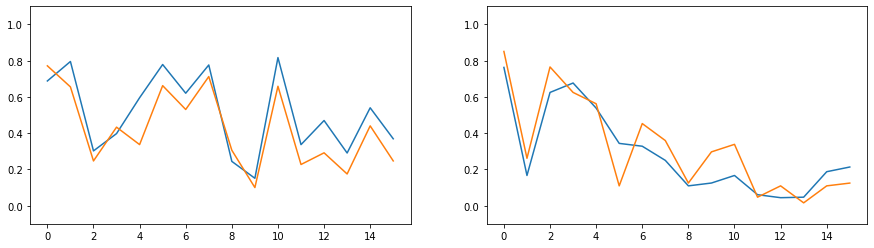

In [13]:
# Plot prob of lick of the two tasks
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(m2['scores'])
axs[0].plot(m1['scores'])
axs[0].set_ylim(-0.1, 1.1)

axs[1].plot(m2_am['scores'])
axs[1].plot(m1_am['scores'])
axs[1].set_ylim(-0.1, 1.1)

In [16]:
stims, names = get_stims('PT')
stims_am, names_am = get_stims('AM')

# Correct for stims_am since go is PT
stims_am[0], stims_am[-1] = stims[0], stims[-1]
names_am[0], names_am[-1] = names[0], names[-1]

IndexError: list index out of range

In [ ]:
# Plot autocorr matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
corr_matrix = np.corrcoef(np.array([s.flatten() for s in stims]))
corr_matrix_am = np.corrcoef(np.array([s.flatten() for s in stims_am]))

go_corr = corr_matrix[0, :]
go_corr_am = corr_matrix_am[0, :]

axs[0].imshow(corr_matrix, vmin=0, vmax=1)
axs[1].imshow(corr_matrix_am, vmin=0, vmax=1)

plt.tight_layout()
plt.show()
plt.close()

fig, axs = plt.subplots(2, figsize=(12, 10))

axs[0].plot(go_corr)
axs[1].plot(go_corr_am)


In [ ]:
def eucl_dist(s, go, nogo):
    s, go, nogo = s.flatten(), go.flatten(), nogo.flatten()
    OA = 0.5 * nogo - 0.5 * go
    norm_AB = np.linalg.norm(nogo - go)
    AD = s - go + OA
    dist = np.dot(AD, OA)/norm_AB
    
    return 0.5*dist

In [ ]:
def try_blur_options(stims, ksizes=np.arange(2, 14, 2), sigmas=np.linspace(0.2, 0.9, 30)):
    correlation_to_go = {}
    for k in ksizes:
        for s in sigmas:
            blurred_stims = blur_stim(stims, ksize=k, sigma=s)
            corrm = np.corrcoef(np.array([bs.flatten() for bs in blurred_stims]))
            key = '{}_{:02f}'.format(k, s)
            correlation_to_go[key] = corrm[0, :]
    
    return correlation_to_go
        

In [ ]:
def try_blur_options_eucl(stims, ksizes=np.arange(2, 20), sigmas=np.linspace(0.2, 1, 30), go=stims[0], nogo=stims[15]):
    correlation_to_go = {}
    for k in ksizes:
        for s in sigmas:
            blurred_stims = blur_stim(stims, ksize=k, sigma=s)
            
            distances = np.array([eucl_dist(s, go, nogo) for s in blurred_stims])
            distances = (distances - np.min(distances))/(np.max(distances) - np.min(distances))
            key = '{}_{:02f}'.format(k, s)
            correlation_to_go[key] = distances
    
    return correlation_to_go
        

In [ ]:
import tensorflow as tf

correlation_to_go = try_blur_options_eucl(stims_am)
plt.figure(figsize=(15, 10))

plt.plot(m1_am['scores'], color='red', linewidth=3, label='scores_M1')
plt.plot(m2_am['scores'], color='pink', linewidth=3, label='scores_M2')

errs = {}
for k in correlation_to_go:
    err = tf.keras.losses.mean_squared_error(m1_am['scores'], correlation_to_go[k]).numpy()
    errs[k] = err
    plt.plot(correlation_to_go[k])

print('Minimal MSE is :', min(errs.values()))
plt.plot(correlation_to_go[min(errs, key=errs.get)], label='eucl_distances')
plt.legend()
# Correlation doesn't seem to explain enough the discrepencies

It seems that kernel size does matter. Would be interesting to compare the values of all best fitting kernel across experiment and mice to see if they match. It is definitely a mix between correlation and some othe factor. Attention to a certain space maybe ? Would be interesting to enhances some part of the stim by 20-30% using a fix sized-kernel. Maybe it can work the same way for the code as the blurring model. 

In [ ]:
# Try to find 10x10 kernel that can match correlations
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense


def corr_curve(y_true, y_pred):
    pred_freq_corr = unique_filter(stims)
    print(pred_freq_corr.shape)

    def t(a): return tf.transpose(a)

    x = pred_freq_corr
    mean_t = tf.reduce_mean(x, axis=1, keepdims=True)
    #cov_t = x @ t(x)
    cov_t = ((x-mean_t) @ t(x-mean_t))/(pred_freq_corr.shape[1]-1)
    cov2_t = tf.linalg.diag(1/tf.sqrt(tf.linalg.diag_part(cov_t)))
    cor = cov2_t @ cov_t @ cov2_t

    # Fin how to compute autocorrelation matrix
    loss = tf.keras.losses.mean_squared_error(y_true, cor[0, :])

    return loss

initializer = tf.keras.initializers.Ones()


stims = np.array(stims).reshape(-1, 10, 10, 1)

inputs = Input((10, 10, 1))
filtered = Conv2D(1, (1, 1), trainable=True, use_bias=True, strides=1, padding='valid', name='filter_layer')(inputs)
out = Reshape((100,))(filtered)


unique_filter = Model(inputs=inputs, outputs=out)
unique_filter.compile(optimizer='adam', loss=corr_curve)

history = unique_filter.fit(stims/255, go_corr,
                          epochs=10,
                          batch_size=1,
                          verbose=0)

stims_filtered = unique_filter(stims/255).numpy()
print(unique_filter.layers[1].get_weights())
for i, s in enumerate(stims_filtered):
    fig, axs = plt.subplots(1, 2)
    
    axs[0].imshow(s.reshape(10, 10), vmin=0, vmax=1)
    axs[1].imshow(stims[i].reshape(10, 10)/255, vmin=0, vmax=1)

    plt.show()
    plt.close()

In [ ]:
OA = 0.5 * stims[15] - 0.5 * stims[0]
norm_AB = np.linalg.norm(stims[15] - stims[0])
distances = []
for s in stims[1:15]:
    AD = s - stims[0] + OA
    distances.append(1 - np.dot(OA, AD)/norm_AB)

plt.plot((distances-np.min(distances))/(np.max(distances) - np.min(distances)))
plt.plot(dats[0][1:15])

In [ ]:
calib_dict = {'10': 0.04,
              '20': 0.2,
              '30': 0.5,
              '40': 0.9,
              '50': 1.4,
              '60': 2.1,
              '70': 2.75,
              '75': 3.1,
              '80': 3.5,
              '85': 3.8,
              '90': 4.0,
              '95': 4.3,
              '100':4.5}
size_px = 0.196 # in mm2

plt.figure(figsize=(12, 12))

data_pts = [int(k) for k in calib_dict]
powers = [v/0.196 for v in calib_dict.values()]


poly = Polynomial.fit(data_pts, powers, 3)
x = np.linspace(0, 100, 1000)
y = poly(x)

min_acti = 10
cstims = []
for s in stims:
    active_units = s[s != 0] # Only compute active units
    active_units = min_acti + active_units * (np.max(powers) - min_acti) # Normalize
    idx_powers = [np.argmin(np.abs(y - a)) for a in active_units]
    s[s != 0] = x[idx_powers]
    cstims.append(s)
